In [237]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from datetime import datetime
from scipy.fft import rfft, rfftfreq
import scipy
from scipy.fft import irfft
from scipy import signal


#Data formatting function turning hhmmss to hh:mm:ss
def func(x):
    s1 = x%100
    s2 = (x//100)%100
    s3 = x//10000
    return s3*3600 + s2*60 + s1



#Defining function for use on time series. An equal length array of times, 'TIME', and values, 'X', is required.

def Fourier(TimeSeriesHeading=[], ValuesHeading=[], FileNames=[], Lowerbound = [], Upperbound = [],
            X_Axis_Label=None, Y_Axis_Label=None, Title=None, Legend_Title=None):
    fig, (ax1, ax2) = plt.subplots((2), figsize=(8, 3))
    ax2.set_title(Title)
    
    sample_rate = 1/10
    bell_window = np.blackman(Upperbound-Lowerbound)
    
    for ts_heading in TimeSeriesHeading:
        for vals_heading in ValuesHeading:
            for filename in FileNames:
                #Read the data for this (timeseries, value heading, filename) combo + taking data from between bound parameters
                data = pd.read_csv(filename, sep=' ')
                time_data_1 = data[ts_heading].iloc[Lowerbound:Upperbound].map(func)
                values_data_1 = data[vals_heading].iloc[Lowerbound:Upperbound]
                values_data_1 = (values_data_1-np.mean(values_data_1))
               
                #Setting sample size
                N = len(time_data_1)
                #Compute the one-dimensional discrete Fourier Transform for real input.
                values_data_1_transformed = scipy.fft.rfft(values_data_1.values)
                #Return the Discrete Fourier Transform sample frequencies 
                sample_freq = scipy.fft.rfftfreq((N), 1/sample_rate)
                #Setting bounds of range where ULF waves occur: 3mhz-6mhz
                values_data_1_transformed[(sample_freq) < 0.003] = 0
                values_data_1_transformed[(sample_freq) > 0.006] = 0
                
                #time_data_1_pre_irfft = time_data_1[:-1]
                #Taking the absolute value of the fourier transform, therefore finding the magnitude of the real and imaginary parts combined
                values_data_1_transformed_irfft = irfft(np.abs(values_data_1_transformed))
                
                values_data_1_transformed_irfft_blackman = np.multiply(bell_window, values_data_1_transformed_irfft)
               
                values_data_1_transformed = np.abs(scipy.fft.rfft((values_data_1_transformed_irfft_blackman)))
                sample_freq = scipy.fft.rfftfreq((N), 1/sample_rate)
                #plt.plot(sample_freq, (values_data_1_transformed))
            
                #Overlay onto the existing plot
                ax1.plot(time_data_1, values_data_1)
                ax2.plot(sample_freq, np.abs(values_data_1_transformed),
                        label=f'{ts_heading}/{vals_heading}/{filename}')
                

    #Add legend after all graphs drawn
    #plt.ylim(0,30)
    ax1.set_ylim(-2,2)
    plt.xlim(0,0.007)
    if Legend_Title == Legend_Title:
            ax2.legend(title = Legend_Title, loc=(1.04, 0))

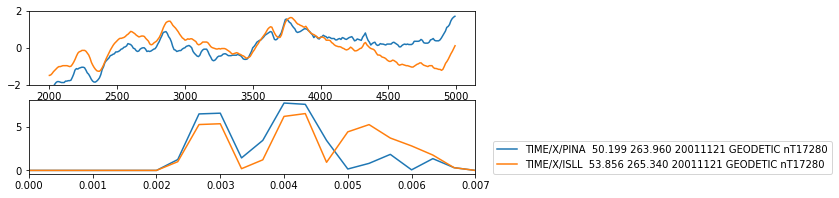

In [238]:
Fourier(['TIME'], ['X'], 
        ["PINA  50.199 263.960 20011121 GEODETIC nT17280","ISLL  53.856 265.340 20011121 GEODETIC nT17280"], Lowerbound = 200, Upperbound = 500)